# Chapter-7 Enseble Learning

## Voting Classifier

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting="hard"
)

In [3]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.896


## Baggin and Pasting

Train the same type of estimators on different sections of the data

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [5]:
print(accuracy_score(y_test, y_pred))

0.92


## Out of Bag Classification

In this, the estimators are evaluated on the part of the training dataset that they didn't train on (this part is different for every estimator) and are averaged out.

In [6]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.8986666666666666

## Random Patches and Random Subspaces

The BaggingClassifier class supports sampling the features as well. Sampling is controlled by two hyperparameters: max_features and bootstrap_features. They work the same way as max_samples and bootstrap, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features.
This technique is particularly useful when you are dealing with high-dimensional inputs (such as images). Sampling both training instances and features is called the Random Patches method. Keeping all training instances (by setting bootstrap=False and max_samples=1.0) but sampling features (by setting bootstrap_features to True and/or max_features to a value smaller than 1.0) is called the Random Subspaces method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

## Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

The Random Forest algorithm introduces extra randomness when growing trees;
instead of searching for the very best feature when splitting a node (see Chapter 6), it searches for the best feature among a random subset of features. The algorithm results in greater tree diversity, which (again) trades a higher bias for a lower variance, generally yielding an overall better model.

## Extra-Trees or Extremely Randomized Trees

When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).
A forest of such extremely random trees is called an Extremely Randomized Trees ensemble (or Extra-Trees for short). Once again, this technique trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular Random Forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

## Feature Importance

Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it

In [8]:
from  sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.1072475033175851
sepal width (cm) 0.021593102079099313
petal length (cm) 0.4108883359531833
petal width (cm) 0.4602710586501323


## Boosting

Boosting (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are AdaBoost (short for Adaptive Boosting) and Gradient Boosting.

### AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost.
For example, when training an AdaBoost classifier, the algorithm first trains a base classifier (such as a Decision Tree) and uses it to make predictions on the training set.
The algorithm then increases the relative weight of misclassified training instances.
Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

Each instance weight w(i) is initially set to 1/m. A first predictor is trained, and its weighted error rate r1
is computed on the training set

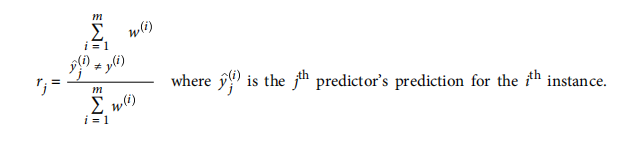

The predictor’s weight αj is then computed using Equation 7-2, where η is the learning rate hyperparameter (defaults to 1).15 The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.

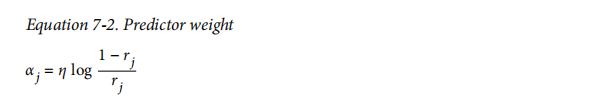

Next, the AdaBoost algorithm updates the instance weights, using Equation 7-3, which boosts the weights of the misclassified instances.

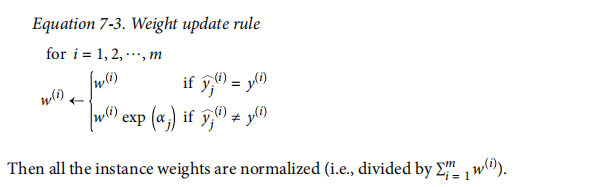

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on). The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.

To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights αj. The predicted class is the one that receives the majority of weighted votes

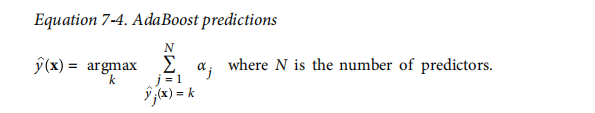

Scikit-Learn uses a multiclasss version of AdaBoost called SAMME (Stagewise Additive Modeling using a Multicalss Exponential loss function). This predicts classes. Scikiet-Learn can also used SAMME.R (R for "real") which relies on class probabilities and performs better

In [9]:
from sklearn.ensemble import AdaBoostClassifier 
# The default base estimator is a decision tree with one decision node and 2 leaf
# i.e. max_depth = 1, this is called a decsion stump
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

## Gradient Boosing

Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

First we train a decision tree 

In [10]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

Next, we’ll train a second DecisionTreeRegressor on the residual errors made by the first predictor:

In [14]:
y2 = y_train - tree_reg1.predict(X_train)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X_train, y2)

DecisionTreeRegressor(max_depth=2)

Then we train a third regressor on the residual errors made by the second predictor:

In [15]:
y3 = y2 - tree_reg2.predict(X_train)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X_train, y3)

DecisionTreeRegressor(max_depth=2)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [16]:
y_pred = sum(tree.predict(X_test) for tree in (tree_reg1, tree_reg2, tree_reg3))

#### Using GradientBoostingRegressor

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)